# Deep Learning HW 3

This code was run on Google Cloud Platform Notebooks, with PyTorch 1.7 and NVIDIA Tesla T4

This notebook
- https://github.com/tonghuikang/flowers-image-classifier/blob/master/homework.ipynb

Code changes relative to the reference repository
- https://github.com/MiguelAMartinez/flowers-image-classifier/compare/master...tonghuikang:master

Logs that are not printed in this notebook
- https://github.com/tonghuikang/flowers-image-classifier/tree/master/logs

In [1]:
from urllib.request import urlopen

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import torch, torchvision

# PART ONE

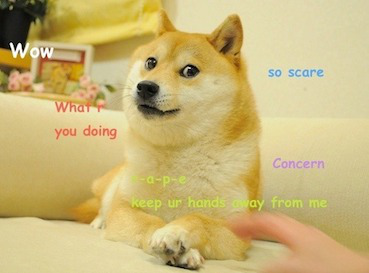

In [2]:
img = Image.open(urlopen("https://upload.wikimedia.org/wikipedia/en/5/5f/Original_Doge_meme.jpg"))
img

In [3]:
# load model
resnet = torchvision.models.resnet101(pretrained=True)

# set network to evaluation mode
resnet.eval()

transform = torchvision.transforms.Compose([
 torchvision.transforms.CenterCrop(224),
 torchvision.transforms.ToTensor(),
 torchvision.transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


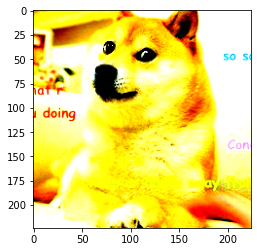

In [4]:
img_t = transform(img)
print(img_t.shape)
plt.imshow(torch.einsum("chw -> hwc", img_t))

In [5]:
batch_t = torch.unsqueeze(img_t, 0)

# perform inference
out = resnet(batch_t)

# lookup the labels
RESNET_LABEL_URL = "https://gist.githubusercontent.com/steverichey/3d87d581a8713e65ac6c2d0848151ff5/raw/272734c0bb45847d47f1ecb1f75b814379a5c3d0/imagenet_labels.txt"
text = urlopen(RESNET_LABEL_URL).read().decode('utf-8')
labels = {i:k for i,k in enumerate(text.split("\n"), start=1)}

# print top-5 classes predicted by model
_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
for idx in indices[0][:5]:
    print('Confidence Score: {:.3f} % - {}'.format(percentage[idx].item(), labels[idx.item()]))

Confidence Score: 61.349 % - coyote
Confidence Score: 5.080 % - curly-coated_retriever
Confidence Score: 3.934 % - Saint_Bernard
Confidence Score: 3.333 % - sea_lion
Confidence Score: 3.098 % - Pomeranian


#### Task

> Modify the code above, to perform data augmentation for the testing sample averaging the scores of 5 crops
> - center crop
> - upper left crop
> - lower left crop
> - lower right crop
> - upper right crop

In [6]:
transform_after_crop = torchvision.transforms.Compose([
 torchvision.transforms.ToTensor(),                     
 torchvision.transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                            
 std=[0.229, 0.224, 0.225]
 )])

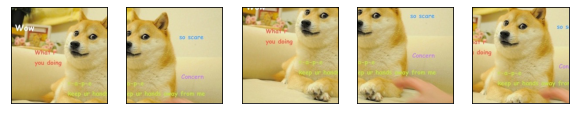

In [7]:
npimg = np.array(img)

crops = [npimg[:224,:224,:], npimg[:224,-224:,:], # top left, top right
         npimg[-224:,:224,:], npimg[-224:,-224:,:], # bottom left, bottom right
         npimg[npimg.shape[0]//2 - 112:npimg.shape[0]//2 + 112,
               npimg.shape[1]//2 - 112:npimg.shape[1]//2 + 112,:]]  # center plot

fig, ax = plt.subplots(1,5,figsize=(10,3))
for i,crop in enumerate(crops):
    ax[i].imshow(crop)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


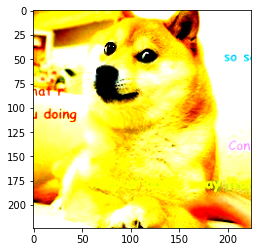

In [8]:
batch_t = torch.stack([transform_after_crop(crop) for crop in crops])
plt.imshow(torch.einsum("chw -> hwc", batch_t[-1]))

In [9]:
# perform inference
out_arr = resnet(batch_t)

all_percentages = np.zeros(1000)

# print top-5 classes predicted by model
for out in out_arr:
    out = torch.stack([out])
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    all_percentages += percentage.detach().numpy()/5
    _, indices = torch.sort(out, descending=True)
    print()
    for idx in indices[0][:5]:
        print('Confidence Score: {:.3f} % - {}'.format(percentage[idx].item(), labels[idx.item()]))


Confidence Score: 18.489 % - Brabancon_griffon
Confidence Score: 17.872 % - sea_lion
Confidence Score: 15.142 % - coyote
Confidence Score: 7.184 % - curly-coated_retriever
Confidence Score: 6.969 % - Samoyed

Confidence Score: 60.893 % - coyote
Confidence Score: 15.535 % - Brabancon_griffon
Confidence Score: 5.338 % - Saint_Bernard
Confidence Score: 4.745 % - malamute
Confidence Score: 4.091 % - sea_lion

Confidence Score: 37.985 % - Pomeranian
Confidence Score: 14.468 % - curly-coated_retriever
Confidence Score: 9.954 % - coyote
Confidence Score: 8.859 % - Saint_Bernard
Confidence Score: 7.722 % - golden_retriever

Confidence Score: 60.922 % - coyote
Confidence Score: 6.452 % - Pomeranian
Confidence Score: 4.968 % - sea_lion
Confidence Score: 4.481 % - Rottweiler
Confidence Score: 4.288 % - Saint_Bernard

Confidence Score: 56.342 % - coyote
Confidence Score: 7.212 % - Saint_Bernard
Confidence Score: 5.337 % - curly-coated_retriever
Confidence Score: 5.210 % - Pomeranian
Confidence Sc

In [10]:
for idx, _ in sorted(enumerate(all_percentages), key=lambda x:x[1])[-5:][::-1]:
    print('Confidence Score: {:.3f} % - {}'.format(all_percentages[idx], labels[idx]))

Confidence Score: 40.651 % - coyote
Confidence Score: 10.719 % - Pomeranian
Confidence Score: 7.659 % - Brabancon_griffon
Confidence Score: 6.266 % - Saint_Bernard
Confidence Score: 5.973 % - sea_lion


Please discuss the advantages and disadvantages of using testing data augmentation.

Advantages
- Data augmentation with corner and center crops allows for different views of the testing data.
- It is important to carry out the same augmentation that is applied on the training data (except distortions), such as normalising and resizing. This allow the test sample to match how the train sample was prepared and is of the correct dimension.

Disadvantages
- If the laballed object is small and is in the center of the picture, the center crops may not capture the object and the prediction will be irrelevant, weakening the confidence of the prediction.

# PART TWO
> (Note: In this task, if you are adapting the code based on the open-source projects, pls acknowledge the original source in your code files, and also clearly mention it in your report. Also you need to clearly highlight which parts are done by yourself)

Please refer to https://github.com/MiguelAMartinez/flowers-image-classifier/compare/master...tonghuikang:master to understand how the code is adapted for this homework

## TASK ONE


> (1) Replace the used base model (densenet169) to another model (refer to https://pytorch.org/vision/0.8/models.html for more types of models). Pls compare the performance of these two models on the validation set. 

In [12]:
!python train.py "./flowers" --arch densenet169 --gpu --epochs=3

Epoch: 0/3 Step: 1 -  Training Loss: 4.721 -  Validation Loss: 4.607 -  Validation Accuracy: 0.030
Epoch: 0/3 Step: 2 -  Training Loss: 4.610 -  Validation Loss: 4.565 -  Validation Accuracy: 0.062
Epoch: 0/3 Step: 5 -  Training Loss: 4.582 -  Validation Loss: 4.488 -  Validation Accuracy: 0.062
Epoch: 0/3 Step: 10 -  Training Loss: 4.596 -  Validation Loss: 4.285 -  Validation Accuracy: 0.129
Epoch: 0/3 Step: 20 -  Training Loss: 4.158 -  Validation Loss: 3.817 -  Validation Accuracy: 0.227
Epoch: 0/3 Step: 51 -  Training Loss: 3.239 -  Validation Loss: 2.264 -  Validation Accuracy: 0.582
Epoch: 1/3 Step: 104 -  Training Loss: 1.756 -  Validation Loss: 0.945 -  Validation Accuracy: 0.840
Epoch: 2/3 Step: 207 -  Training Loss: 0.834 -  Validation Loss: 0.416 -  Validation Accuracy: 0.907
Epoch: 3/3 Step: 310 -  Training Loss: 0.490 -  Validation Loss: 0.306 -  Validation Accuracy: 0.934
model: densenet169 - hidden layers: [1024] - epochs: 3 - lr: 0.001
Run time: 5.523 min


In [13]:
!python train.py "./flowers" --arch resnet18 --gpu --epochs=3

Epoch: 0/3 Step: 1 -  Training Loss: 4.758 -  Validation Loss: 4.615 -  Validation Accuracy: 0.029
Epoch: 0/3 Step: 2 -  Training Loss: 4.576 -  Validation Loss: 4.578 -  Validation Accuracy: 0.026
Epoch: 0/3 Step: 5 -  Training Loss: 4.549 -  Validation Loss: 4.503 -  Validation Accuracy: 0.048
Epoch: 0/3 Step: 10 -  Training Loss: 4.477 -  Validation Loss: 4.248 -  Validation Accuracy: 0.124
Epoch: 0/3 Step: 20 -  Training Loss: 4.152 -  Validation Loss: 3.795 -  Validation Accuracy: 0.229
Epoch: 0/3 Step: 51 -  Training Loss: 3.265 -  Validation Loss: 2.301 -  Validation Accuracy: 0.552
Epoch: 1/3 Step: 104 -  Training Loss: 1.943 -  Validation Loss: 1.092 -  Validation Accuracy: 0.774
Epoch: 2/3 Step: 207 -  Training Loss: 1.030 -  Validation Loss: 0.524 -  Validation Accuracy: 0.896
Epoch: 3/3 Step: 310 -  Training Loss: 0.674 -  Validation Loss: 0.417 -  Validation Accuracy: 0.905
model: resnet18 - hidden layers: [1024] - epochs: 3 - lr: 0.001
Run time: 4.215 min


## TASK TWO

> (2) Please try different training methods that use densenet169 as the base model and compare their performance on the validation set.
> - finetuning the model but only updating the top layers
> - finetuning the whole model
> - training the whole model from scratch

Please also draw the curves of training/validation losses over training steps for these methods, and give your analysis based on the observed curves.

### Finetuning the model but only updating the top layers

In [14]:
# !python train.py "./flowers" --arch densenet169 --gpu --epochs=100 > ./logs/finetune_only_top_layer.txt

### Finetuning the whole model

In [15]:
# !python train.py "./flowers" --arch densenet169 --gpu --train_all_layers --epochs=100 > ./logs/finetune_whole_model.txt

### Training the whole model from scratch

In [46]:
# !python train.py "./flowers" --arch densenet169 --gpu --not_use_pretrained --train_all_layers --epochs=100 > ./logs/train_from_scratch.txt

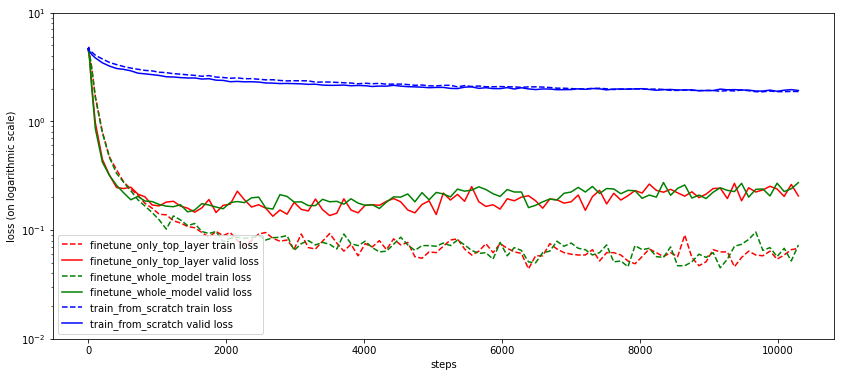

In [11]:
import matplotlib.pyplot as plt

def compare_loss(files, colors, ymin=0.1):
    plt.figure(figsize=(14,6))

    for file, color in zip(files, colors):
        with open("./logs/{}.txt".format(file), "r") as f:
            text = f.readlines()
            steps = []
            loss_train = []
            loss_valid = []
            for line in text:
                words = line.split()
                if words[0] != "Epoch:": continue
                steps.append(int(words[3]))
                loss_train.append(float(words[7]))
                loss_valid.append(float(words[11]))
            plt.plot(steps, loss_train, label="{} train loss".format(file), ls="--", color=color)
            plt.plot(steps, loss_valid, label="{} valid loss".format(file), ls="-", color=color)

    plt.ylabel("loss (on logarithmic scale)")
    plt.xlabel("steps")
    plt.yscale("log")
    plt.ylim(ymin,10)
    plt.legend()
    plt.show()

compare_loss(["finetune_only_top_layer", "finetune_whole_model", "train_from_scratch"], ["r", "g", "b"], ymin=0.01)

Training from scratch results in a very slow convergence because all the weights needed to be trained from scratch. The loss it converges to is higher because it did not take advantage from the pretrained weights learnt from a far bigger dataset. There are only 8189 flowers in the dataset, whereas the imagenet dataset contains millions of pictures.

Finetuning pretrained model, whether is it just the full model or the last layer, allow us to achieve low loss quickly.

Both the finetuning of the whole model and the finetuning of the top layer overfitted soon after achieving low validation loss. This is because the number of paramters trained is much larger than the number of flowers.

The overfitting did not result in huge increases in validation loss. I suspect that this is due to the dropout that we have implemented in the final layer that prevented the model from overfitting badly.

I would have expected the finetuning of the whole model to overfit more because the number of parameters is much larger than the number of samples. This does not appear to be the case as the training and validation loss closely match each other. Again, I suspect that this is due to the dropout implemented in the final layer.

## TASK THREE

> (3) For the model based on densenet169, please also report its performance (when you use the training method of finetuning the model but only updating the top layers) on the testing set.

In [29]:
!python train.py "./flowers" --arch densenet169 --gpu --test_model --epochs=3

Epoch: 0/3 Step: 1 -  Training Loss: 4.648 -  Validation Loss: 4.593 -  Validation Accuracy: 0.026
Epoch: 0/3 Step: 2 -  Training Loss: 4.653 -  Validation Loss: 4.578 -  Validation Accuracy: 0.025
Epoch: 0/3 Step: 5 -  Training Loss: 4.674 -  Validation Loss: 4.491 -  Validation Accuracy: 0.066
Epoch: 0/3 Step: 10 -  Training Loss: 4.430 -  Validation Loss: 4.290 -  Validation Accuracy: 0.117
Epoch: 0/3 Step: 20 -  Training Loss: 4.020 -  Validation Loss: 3.780 -  Validation Accuracy: 0.145
Epoch: 0/3 Step: 51 -  Training Loss: 3.135 -  Validation Loss: 2.186 -  Validation Accuracy: 0.602
Epoch: 1/3 Step: 104 -  Training Loss: 1.695 -  Validation Loss: 0.878 -  Validation Accuracy: 0.845
Epoch: 2/3 Step: 207 -  Training Loss: 0.783 -  Validation Loss: 0.443 -  Validation Accuracy: 0.908
Epoch: 3/3 Step: 310 -  Training Loss: 0.463 -  Validation Loss: 0.297 -  Validation Accuracy: 0.928
model: densenet169 - hidden layers: [1024] - epochs: 3 - lr: 0.001
Run time: 5.569 min
Testing Accur

For this task, I added an option to run the code to test the model.

## TASK FOUR

> (4) Please replace the base model to a new model which contains some convolutional layers. You need to write this new model by yourselves, and then report its performance on the validation set. Note, pls try different numbers of convolutional layers for your model, and compare their results, and give analysis for the results. You need to try at least 2 different numbers of conv layers.

The new model `homemade_CNN` defined in `model_ic.py`. 

`homemade_CNN_small` contains two convolutional layers while `homemade_CNN_large` contains four convolutional layers.

In [42]:
# !python train.py "./flowers" --arch homemade_CNN_small --is_homemade --gpu --epochs=100 > ./logs/homemade_CNN_small.txt

In [43]:
# !python train.py "./flowers" --arch homemade_CNN_large --is_homemade --gpu --epochs=100 > ./logs/homemade_CNN_large.txt

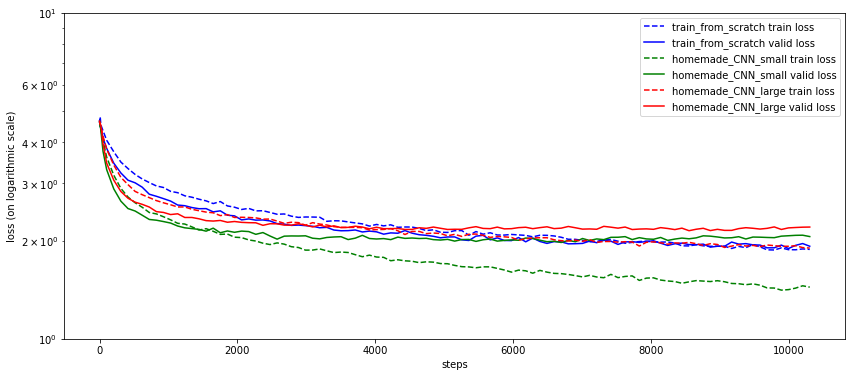

In [12]:
compare_loss(["train_from_scratch", "homemade_CNN_small", "homemade_CNN_large"], ["b", "g", "r"], ymin=1)

The small CNN network (2 convolutional layers) starts to overfit at the 10th epoch, whereas the larger CNN network (4 convolutional layers) overfits later at the 40th epoch.
- Overfitting is observed when the training loss is significantly lower than the validation loss.
- I suggest that this because the of the small amount of parameters the smaller CNN network has.

The larger CNN network did not achieve a lower validation loss.
- I suspect that this is because of the lack of meaningful combination of the extra convolutional layers.

Training from scratch results in a lower validation loss.
- I suspect that this is due better combination of the convolutional layers.
- The output size decreases down the dense block (due to average pooling in the transition layer), results in better abstraction of the features.

## Extra tasks (not included in Homework 3)

(5) Please try using two different learning rate scheduling schemes for densenet169, and compare the performance on the validation set.

(6) Please try using two different optimizers for densenet169, and compare the performance on the validation set.

In [13]:
!jupyter nbconvert --to script homework.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook homework.ipynb to script
[NbConvertApp] Writing 11250 bytes to homework.py
